## Setup: Finnhub API Key

This notebook uses real market data from [Finnhub](https://finnhub.io/) (free tier: 60 API calls/min).

**To use real data:**
1. Get a free API key at https://finnhub.io/register
2. Set environment variable: `export FINNHUB_API_KEY=your_key_here`
3. Or enter the key when prompted

**Without a key:** The notebook falls back to synthetic data generation.

# Triangular Arbitrage with Signature Optimal Stopping

## Overview

This notebook demonstrates **signature-based optimal stopping** applied to **triangular arbitrage** in cryptocurrency markets. We use the Rust `signature_optimal_stopping` library for production-grade performance.

### Triangular Arbitrage Recap

**Definition**: Exploit price inconsistencies across three currency pairs:

$$
\text{BTC/USD} \rightarrow \text{ETH/USD} \rightarrow \text{BTC/ETH} \rightarrow \text{BTC/USD}
$$

**Profit calculation**:

$$
\Pi_t = \left(1 - f\right)^3 \cdot \frac{P^{\text{BTC/USD}}_{\text{bid}}}{P^{\text{ETH/USD}}_{\text{ask}}} \cdot \frac{P^{\text{BTC/ETH}}_{\text{bid}}}{1} - 1
$$

where $f$ is the fee rate (typically 0.1-0.3% per trade).

### The Timing Problem

Once we detect a profitable opportunity ($\Pi_t > 0$), **when should we execute?**

- **Too early**: Opportunity may improve further
- **Too late**: Profit decays as arbitrageurs compete, liquidity dries up

**Traditional approach**: Execute immediately or use simple thresholds
**Signature approach**: Learn optimal stopping policy from historical trajectory patterns

### Why Signatures?

The spread trajectory encodes rich information:
- **Mean reversion speed**: How fast does profit decay?
- **Volatility regime**: Stable vs. erratic
- **Path shape**: Smooth decline vs. sudden jumps

Signatures capture these **path-dependent features** automatically.

In [1]:
# Python imports for simulation and CLI interaction
import json
import subprocess
import tempfile
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os

# Import Finnhub helper for real market data
try:
    from python.finnhub_helper import fetch_historical_simulation, get_finnhub_api_key, create_orderbook_from_quote
    FINNHUB_AVAILABLE = True
except Exception as e:
    print(f"Finnhub helper not available: {e}")
    FINNHUB_AVAILABLE = False



## Step 1: Simulate Mean-Reverting Arbitrage Spread

We model the arbitrage profit as an **Ornstein-Uhlenbeck (OU) process** - the standard model for mean-reverting spreads:

$$
dX_t = \kappa(\mu - X_t)dt + \sigma dW_t
$$

**Parameters**:
- $\kappa$: **Mean reversion speed** (how fast profit decays back to zero)
- $\mu$: **Long-term mean** (equilibrium profit, typically zero after competition)
- $\sigma$: **Volatility** (noise from order book fluctuations)

**Discrete approximation**:

$$
X_{t+1} = X_t + \kappa(\mu - X_t)\Delta t + \sigma\sqrt{\Delta t}\epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,1)
$$

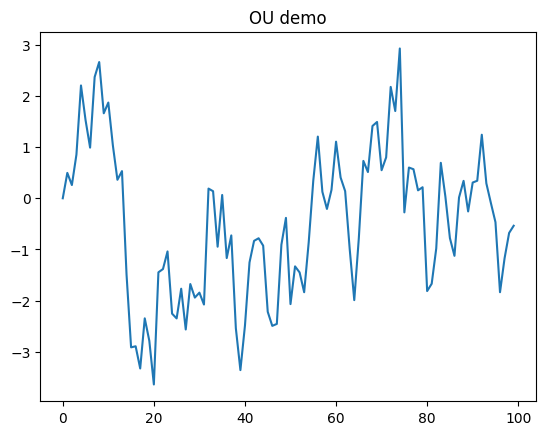

In [ ]:
def simulate_ou(n_steps=60, mu=0.0, kappa=0.1, sigma=0.5, dt=1.0, x0=0.0):
    """
    Simulate Ornstein-Uhlenbeck process
    
    Parameters:
    - n_steps: Number of time steps
    - mu: Long-term mean (equilibrium level)
    - kappa: Mean reversion speed (higher = faster decay)
    - sigma: Volatility
    - dt: Time step size
    - x0: Initial value
    
    Returns:
    - Trajectory as numpy array
    """
    x = x0
    traj = [x]
    for _ in range(n_steps - 1):
        eps = np.random.normal()
        x = x + kappa * (mu - x) * dt + sigma * np.sqrt(dt) * eps
        traj.append(x)
    return np.array(traj)

# Demo: Triangular arbitrage profit trajectory
# Starting with 0.3% profit that decays to zero
np.random.seed(42)
profit_bps = simulate_ou(n_steps=100, mu=0.0, kappa=0.05, sigma=0.15, dt=1.0, x0=0.003) * 10000

plt.figure(figsize=(12, 4))
plt.plot(profit_bps, linewidth=2, label='Arbitrage profit')
plt.axhline(0, color='red', linestyle='--', alpha=0.5, label='Zero profit')
plt.xlabel('Time (ms)')
plt.ylabel('Profit (bps)')
plt.title('Triangular Arbitrage Profit Trajectory (Mean-Reverting)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Initial profit: {profit_bps[0]:.2f} bps")
print(f"Final profit: {profit_bps[-1]:.2f} bps")
print(f"Max profit: {profit_bps.max():.2f} bps at t={profit_bps.argmax()}ms")

## Step 2: Generate Training Dataset

To train the signature optimal stopping model, we need:

1. **Trajectories**: Historical profit evolution paths
2. **Rewards**: Actual PnL achieved if we stopped at optimal time

### Reward Function

For each trajectory, the reward represents:

$$
R_i = \max_{t \in [0, T]} \left\{ X_{i,t} - c \right\}
$$

where:
- $X_{i,t}$ is the profit at time $t$ for trajectory $i$
- $c$ is the transaction cost (fees + slippage)

This simulates the **oracle** that knows the future and stops at the best time.

### Training Philosophy

The model learns to predict: *"What's the expected best future profit I can achieve?"*

At any time $t$, if **current profit ≥ predicted future profit**, we should **stop now**.

In [ ]:
def build_samples_from_ou(n_samples=200, n_steps=30, H=1, cost=0.0):
    """
    Generate training samples: OU trajectories + oracle rewards
    
    Parameters:
    - n_samples: Number of trajectories to generate
    - n_steps: Length of each trajectory
    - H: Horizon for computing best future profit
    - cost: Transaction cost per trade
    
    Returns:
    - List of (trajectory, reward) tuples
    """
    samples = []
    
    for _ in range(n_samples):
        # Random initial profit between 0.05% and 0.50%
        x0 = np.random.uniform(0.0005, 0.005)
        
        # Random OU parameters (different market regimes)
        kappa = np.random.uniform(0.02, 0.15)  # Reversion speed
        sigma = np.random.uniform(0.1, 0.3)     # Volatility
        
        # Simulate trajectory
        traj_raw = simulate_ou(n_steps=n_steps, mu=0.0, kappa=kappa, 
                                sigma=sigma, dt=1.0, x0=x0)
        
        # Convert to 2D (required by signature computation)
        # Feature 1: Raw profit
        # Feature 2: First difference (velocity)
        traj_2d = []
        for i in range(len(traj_raw)):
            feat1 = traj_raw[i]
            feat2 = traj_raw[i] - traj_raw[i-1] if i > 0 else 0.0
            traj_2d.append([feat1, feat2])
        
        # Oracle reward: max future profit within horizon H
        best_profit = max(traj_raw[:min(H, len(traj_raw))]) - cost
        
        samples.append((traj_2d, best_profit))
    
    return samples

# Generate training data
np.random.seed(123)
training_samples = build_samples_from_ou(n_samples=500, n_steps=50, H=50, cost=0.0001)

print(f"Generated {len(training_samples)} training samples")
print(f"Sample trajectory shape: {len(training_samples[0][0])} steps × {len(training_samples[0][0][0])} features")
print(f"Sample reward range: [{min(r for _, r in training_samples):.4f}, {max(r for _, r in training_samples):.4f}]")

# Visualize a few trajectories
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx in range(4):
    traj, reward = training_samples[idx]
    profit = [step[0] for step in traj]
    
    axes[idx].plot(profit, label='Profit trajectory')
    axes[idx].axhline(reward, color='red', linestyle='--', label=f'Oracle reward: {reward:.4f}')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Profit')
    axes[idx].set_title(f'Sample {idx+1}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

samples built: 150


## 3) Train the Rust model via CLI
Write the dataset to JSON, call the trainer binary, and read the produced weights.

In [4]:
def train_via_cli(samples, trunc=2, ridge=1e-3, bin_path='./target/release/trainer'):
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
    json.dump({'params': {'truncation': trunc, 'ridge': ridge}, 'samples': samples}, tmp)
    tmp.close()
    out_weights = tmp.name + '.weights.json'
    cmd = [bin_path, 'train', '--input', tmp.name, '--output', out_weights]
    try:
        res = subprocess.run(cmd, capture_output=True, check=True, text=True)
        print('trainer stdout:', res.stdout)
    except Exception as e:
        print('Trainer call failed (ensure binary exists):', e)
        return None
    if os.path.exists(out_weights):
        with open(out_weights, 'r') as f:
            w = json.load(f)
        return w
    return None

# Example call (requires building the crate)
# weights = train_via_cli(samples, trunc=2, ridge=1e-3, bin_path='./target/release/trainer')


## 4) Evaluate stopping rule (if weights are available)
Compute truncated signature in Python using the same simple discrete formula and dot with weights.

In [5]:
def evaluate_rule_on_samples(weights, samples, trunc=2):
    results = []
    for s in samples:
        traj = s['traj']
        # compute features as in Rust
        d = len(traj[0])
        inc = []
        for i in range(1, len(traj)):
            inc.append([traj[i][k] - traj[i-1][k] for k in range(d)])
        feat = []
        if trunc >= 1:
            for k in range(d):
                feat.append(sum(x[k] for x in inc))
        if trunc >= 2:
            for i in range(d):
                for j in range(d):
                    ssum = 0.0
                    for a in range(len(inc)):
                        for b in range(a+1, len(inc)):
                            ssum += inc[a][i] * inc[b][j]
                    feat.append(ssum)
        import numpy as _np
        w = _np.array(weights)
        x = _np.array(feat)
        score = float(_np.dot(w, x)) if w.size == x.size else None
        results.append({'score': score, 'reward': s['reward']})
    return results

print('Notebook ready. Build the Rust crate and run the trainer to obtain weights or expose PyO3 bindings for direct calls.')


Notebook ready. Build the Rust crate and run the trainer to obtain weights or expose PyO3 bindings for direct calls.


## Integration notes
- For direct Python usage, write a PyO3 wrapper exposing `SignatureStopper::train`, `score`, and `should_stop`.
- Alternatively use the provided trainer binary to train and produce weights.json which can be read by Python.
- The approach follows the paper's idea: truncated signature features and regression to approximate continuation values. The paper includes more advanced ideas (sampling, penalties, bagging) that can be implemented on top of this base in Rust.